# Проверка гипотез сервиса аренды самокатов GoFast

**Цели исследования:** 

- проверить гипотезу: тратят ли пользователи с подпиской больше времени на поездки? 
- проверить гипотезу: можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров? 
- проверить гипотезу: будет ли выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки? 

**Описание данных:**

для проведения анализа представлены данные сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также о поездках этих пользователей. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться без подписки либо с подпиской Ultra. В основных данных есть информация о пользователях, их поездках и подписках, а также дополнительная информация — о количестве обращений пользователей в техподдержку сервиса до и после обновления технической инфраструктуры. Ниже приведен перечень представленных даных: 

- пользователи — users_go.csv
- поездки — rides_go.csv
- подписки — subscriptions_go.csv

**План работы:**

1. открыть файл с данными и изучить общую информацию
2. выполнить предобработку данных
3. провести исследовательский анализ данных, в ходе которого описать и визуализировать указанную ниже информацию о пользователях и их поездках:
- частота встречаемости городов
- соотношение пользователей с подпиской и без подписки
- расстояние и время поездок для пользователей с подпиской и без подписки
- возраст пользователей
- расстояние, которое пользователь преодолел за одну поездку
- продолжительность поездок
4. добавить в датафрейм столбец с помесячной выручкой, которую принес каждый пользователь
5. проверить гипотезы, указанные в целях исследования
6. выяснить какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%
7. оценить вероятность того, что рассылаемые отделом маркетинга в мобильном приложении push-уведомления откроют не более 399,5 тыс. пользователей
5. сформулировать общий вывод

#### Шаг 1. Загрузка данных

In [1]:
# импортируем нужные библиотеки
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
from math import sqrt

In [2]:
try:
    users = pd.read_csv('/datasets/users_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    
try:
    rides = pd.read_csv('/datasets/rides_go.csv')
except:
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

try:
    subs = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    subs = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

# выводим основную информацию о датафреймах с помощью метода info()
users.info()
print()
rides.info()
print()
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   C

Таким образом, у нас есть три датафрейма. Из них:
1. в датафрейме users 5 столбцов, они содержат информацию о пользователях сервиса: id (целочисленный тип данных), имени пользователя (текстовый тип), его возрасте (целочисленный тип), городе (текстовый тип) и наличии подписки (текстовый тип)
2. в датафрейме rides 4 столбца, они содержат информацию о поездках пользователей сервиса: id (целочисленный тип данных), расстоянии (вещественный тип), продолжительности поездки (вещественный тип) и дате поездки (текстовый тип)  
3. в датафрейме subs 4 столбца, они содержат информацию о подписках пользователей: типе подписки (текстовый тип данных), стоимости минуты поездки (целочисленный тип), стоимости старта поездки (целочисленный тип) и размере абонентской платы (целочисленный тип).

При изучении информации о датафреймах мы видим, что в столбце date датафрейма rides информация о дате поездки указана в текстовом формате. Мы приведем ее к типу даты Pandas на следующем шаге (т.е. в ходе предобработки данных). 
Названия столбцов во всех трех датафреймах соответствуют змеиному регистру, поэтому менять их мы не будем. 

In [3]:
# выведем первые 20 строчек датафрейма users на экран
users.head(20)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
# выведем первые 20 строчек датафрейма rides на экран
rides.head(20)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [5]:
# выведем первые 20 строчек датафрейма subs на экран
subs.head(20)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Как мы видим, в датафрейме subs всего две строки, соответствующих типам подписки: free (т.е. без подписки) и ultra (с подпиской). Также видим, что в выведенных на экран строчках всех трех датафреймах отсутствуют пропуски. Поиск пропущенных значений и дубликатов в датафреймах проведем на следующем шаге исследования.	   

In [6]:
users.describe() # запрашиваем распределение по каждому из столбцов датафрейма users

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


Изучая полученную информацию по столбцам user_id и age (т.к. числовые значения есть только в них), видим, что id пользователей принимает значения в диапазоне от 1 до 1 534, а возраст пользователей - от 12 до 43 лет. Видимых противоречий здесь нет, что может говорить в пользу отсутствия выбросов.

In [7]:
rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


Изучая распределение по столбцам датафрейма rides видим, что:
- id пользователей принимает значения в диапазоне от 1 до 1 534 (т.е. как и в датафрейме users)
- расстояние поездки принимает значение от 0.855683 до 7211.007745 при медиане 3133.609994 и среднем 3070.659976. Очевидно, что речь идет о метрах: поездка в 3 км на самокате не вызывает какого-либо противоречия, при этом длина поездки в 86 см может быть объяснено как ошибкой в данных, так и отказом пользователя от поездки
- продолжительность поездки находится в диапазоне от 0.500000 до 40.823963 при среднем 17.805011 и медиане 17.678395. Очевидно, что речь идет о минутах. Тогда типичная поездка на самокате - это поездка на расстояние 3,1 км и продолжительностью 17,7 мин., что соответствует скорости примерно 10,5 км/ч (что также выглядит вполне разумно)

Информацию о распределении для датафрейма subs мы выводить не будем, т.к. данная таблица содержит всего 2 строки (см. выше)

Теперь мы можем перейти к предобработке данных

#### Шаг 2. Предобработка данных

In [8]:
# приведем данные в столбце date к типу даты Pandas
#rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%dT%H') 
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d') 
# создаем новый столбец с номером месяца на основе столбца date
rides['month'] = rides['date'].dt.month
rides.info()
rides.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB


,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


Мы вывели информацию о датафрейме на экран и видим, что информация о дате поездки успешно приведена к типу даты Pandas. Также в датафрейме появился новый столбец с номером месяца. 

Теперь займемся поиском пропущенных значений и дубликатов.

In [9]:
# проверим количество пропусков в % для датафрейма users
pd.DataFrame(round(users.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
name,0.000000
age,0.000000
city,0.000000
subscription_type,0.000000


In [10]:
# проверим количество пропусков в % для датафрейма rides
pd.DataFrame(round(rides.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
distance,0.000000
duration,0.000000
date,0.000000
month,0.000000


Таким образом, в датафреймах users и rides отсутствуют пропущенные значения. Датафрейм subs мы ранее вывели на экран полностью (т.к. он состоит из всего двух строк), пропусков в нем также нет.

Перейдем к поиску дубликатов.

Учитывая, что:
- числовые значения (например, такие, как возраст, расстояние, продолжительность поездки) вполне могут совпадать у разных пользователей
- разные пользователи также могут иметь одинаковые имена (при том, что в представленных данных есть только имена пользователей, без имен и отчеств, а идентификация проводится по id)
- разные пользователи вполне могут проживать в одном городе (и при этом также иметь одинаковые имена)
- разные пользователи вполне могли совершать поездки на самокатах в одну и ту же дату (день, месяц и год)
- разные пользователи могли совершать поездки на самокате неоднократно, поэтому их id может встречаться в таблицах также не один раз

мы не можем сделать однозначный вывод о наличии в датафреймах дубликатов. Поэтому выведем на экран уникальные значения столбцов name, city, subscription_type датафрейма users и проверим их на наличие явных опечаток/ошибок (датафрейм rides содержит только номер пользователя, расстояние, продолжительность и дату поездки, а датафрейм subs мы уже анализировали: он состоит из двух строк, пропусков и дубликатов в нем нет). Стоит отметить, что такой подход не является препятствием для качественного выполнения целей исследования.

In [11]:
# выведем список уникальных значений столбца name датафрейма users
users['name'].sort_values().unique()

array(['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра',
       'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина',
       'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий',
       'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина',
       'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём',
       'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия',
       'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника',
       'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад',
       'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей',
       'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила',
       'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий',
       'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена',
       'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар',
       'Злата', 

In [12]:
# выведем список уникальных значений столбца city датафрейма users
users['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

In [13]:
# выведем список уникальных значений столбца subscription_type датафрейма users
users['subscription_type'].sort_values().unique()

array(['free', 'ultra'], dtype=object)

Анализируя полученные уникальные значения столбцов, мы видим, что среди имен пользователей и названий городов отсутствуют опечатки/ошибки. Для столбца subscription_type имеется только два типа подписки: free (т.е. без подписки) и ultra (с абонентской платой 199 рублей в месяц), что является корректным. Таким образом, неявные дубликаты отсутствуют.

Проведем проверку на наличие явных дубликатов.



In [14]:
# Код ревьюера
users.duplicated().sum()

31

In [15]:
users[users.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


Мы вывели на экран все строки с дубликатами. Видим, что они индут по порядку от 1534-й до 1564-й строки. Возможно, наличие дубликатов свзязано с техническими причинами (т.е. сбоем при записи информации).

In [16]:
# удалим явные дубликаты
users = users.drop_duplicates().reset_index(drop=True)

In [17]:
# вновь проверим на наличие дубликатов
users.duplicated().sum()

0

In [18]:
# проверим на наличие дубликатов датафрейм rides. Датафрейм subs мы ранее вывели на экран полностью (т.к. он состоит из
# всего двух строк), дубликаты и пропуски в нем отсутствуют
rides.duplicated().sum()

0

Как мы видим, пропуски и дубликаты в датафреймах отсутствуют. Т.е. данные готовы для проведения дальнейшего исследования и мы можем переходить к третьему шагу - исследовательскому анализу данных.

#### Шаг 3. Исследовательский анализ данных

**Изучение частоты встречаемости городов**

In [19]:
# посмотрим распределение по столбцу с названиями городов
users['city'].describe()

count          1534
unique            8
top       Пятигорск
freq            219
Name: city, dtype: object

In [20]:
# посмотрим на количество значений в каждой категории 
users['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

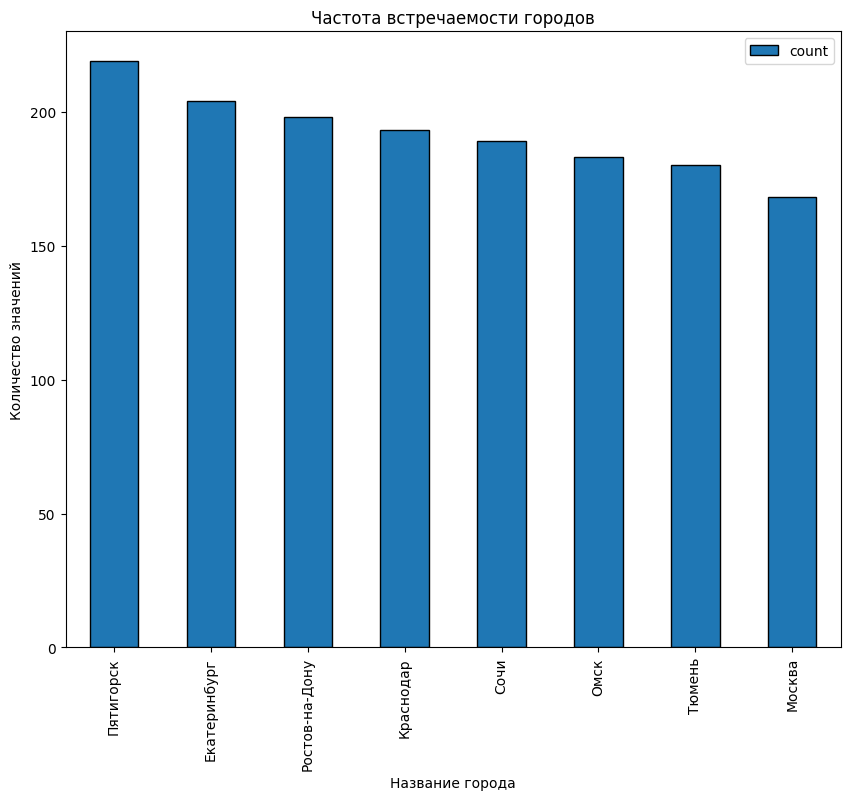

In [21]:
# отобразим это на графике
users['city'].value_counts().plot.bar(figsize=(10, 8), ec='black', legend=True)
plt.title('Частота встречаемости городов')
plt.xlabel('Название города')
plt.ylabel('Количество значений')
plt.show()

<Axes: ylabel='city'>

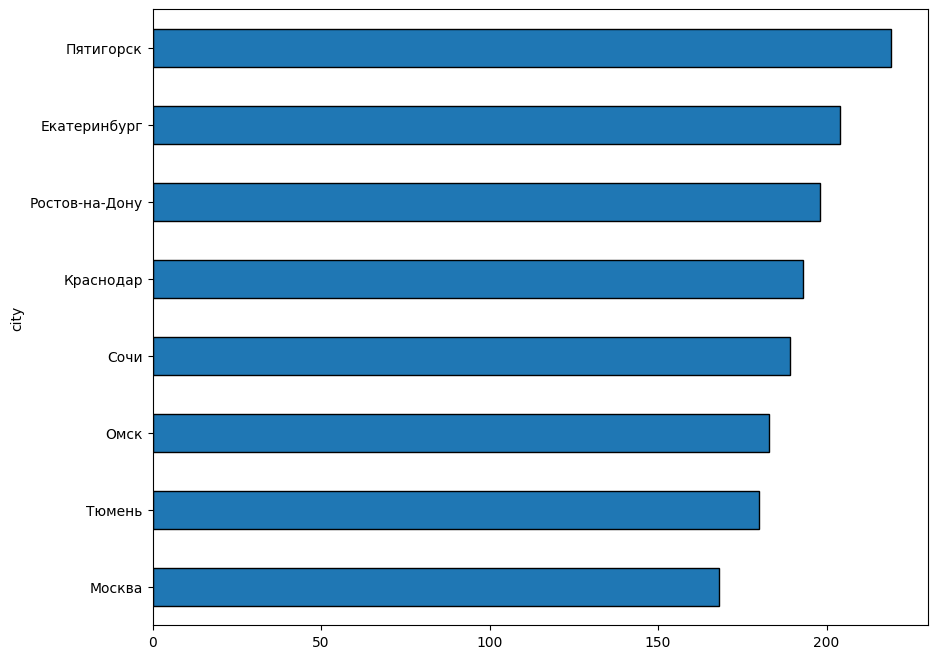

In [22]:
users['city'].value_counts(ascending = True).plot.barh(figsize=(10, 8), ec='black')

Как мы видим, наиболее часто в представленных данных встречается Пятигорск. В первую тройку входят также Екатеринбург и Ростов-на-Дону. Замыкает список городов Москва: в представленных данных этот город встречается реже всех. Такое распределение связано, скорее всего, с плотностью клиентской базы сервиса GoFast в различных городах.

**Изучение соотношения пользователей с подпиской и без подписки**

In [23]:
# посмотрим на количество значений в каждой категории 
users['subscription_type'].value_counts()

subscription_type
free     835
ultra    699
Name: count, dtype: int64

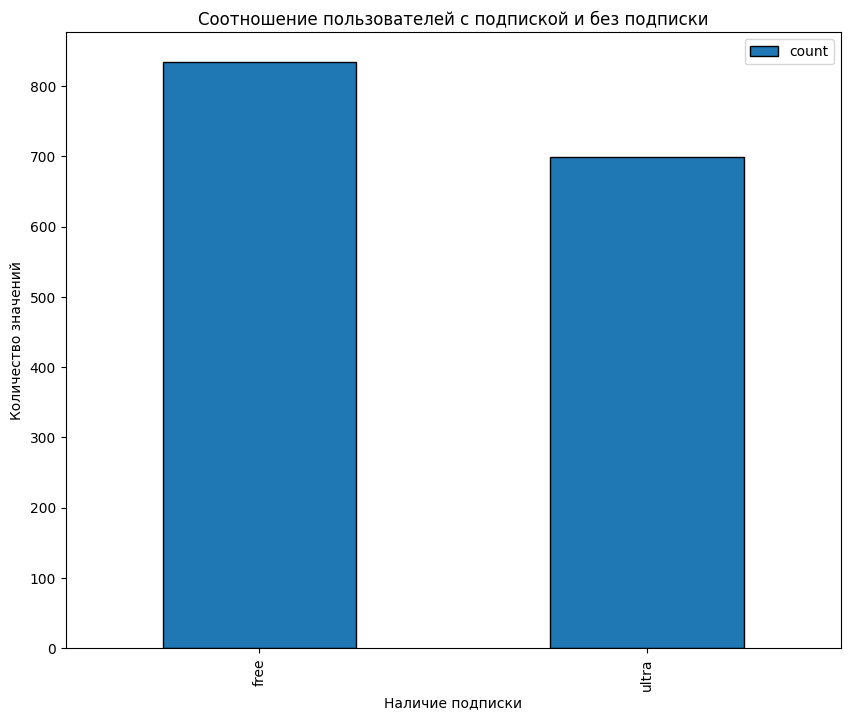

In [24]:
# отобразим это на графике
users['subscription_type'].value_counts().plot.bar(figsize=(10, 8), ec='black', legend=True)
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.xlabel('Наличие подписки')
plt.ylabel('Количество значений')
plt.show()

Как мы видим, большинство клиентов сервиса GoFast пользуются сервисом без подписки (846 против 719). При этом количество имеющих подписку пользователей составляет примерно 46% от общего количества клиентов).

**Изучение возраста пользователей**

In [25]:
# посмотрим распределение по столбцу с возрастом пользователей
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [26]:
# посмотрим на количество значений в каждой категории 
users['age'].value_counts()

age
25    145
24    132
26    131
23    129
22    119
27    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
16     19
34     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: count, dtype: int64

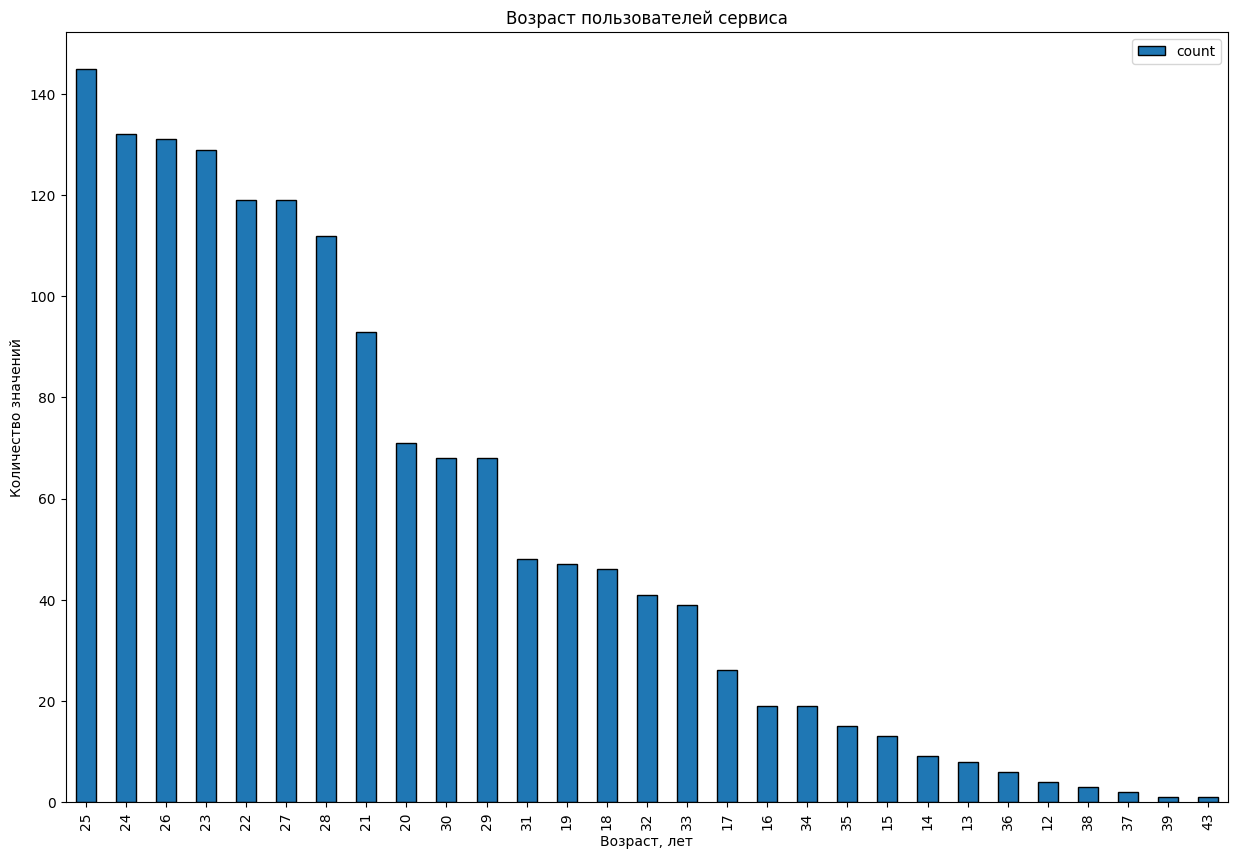

In [27]:
# отобразим это на графике
users['age'].value_counts().plot.bar(figsize=(15, 10), ec='black', legend=True)
plt.title('Возраст пользователей сервиса')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество значений')
plt.show()

Как мы видим, большая часть пользователей сервиса - это люди возраста от 22 до 28 лет включительно (в каждой из этих возрастных категорий количество пользователей превышает 100), при этом максимум приходится на возраст 25 лет. Пользователи иных возрастов встречаются существенно реже. Причем меньше всего пользователей, возраст которых близок к 40 годам (на графике это 37, 38, 39 и 43 года), минимум приходится на 39 и на 43 года (таких пользователей всего по одному в каждом из этих возратов)

In [28]:
# посмотрим распределение по столбцу с расстояниями поездок
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

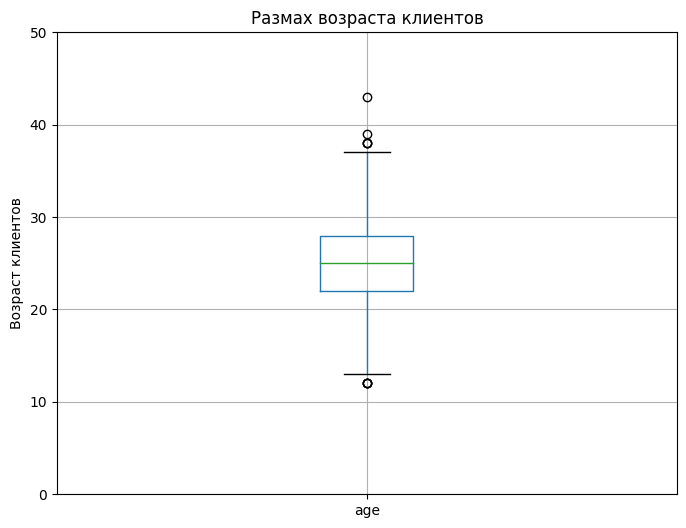

In [29]:
# посторим диаграмму размаха
users.boxplot(column='age', figsize=(8, 6))
plt.title('Размах возраста клиентов')
plt.ylim(0, 50)
plt.ylabel('Возраст клиентов')
plt.show()

Из графика мы видим, что ориентировочная граница нормального размаха расстояния, которое пользователь преодолел за одну поездку, составляет от 13 до 48 лет. Более высокие и более низкие значения являются выбросами (на графике они представлены отдельными точками, что говорит о том, что их количество невелико). Медиана - 25 лет

**Изучение расстояния, которое пользователь преодолел за одну поездку**

In [30]:
# посмотрим распределение по столбцу с расстояниями поездок
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

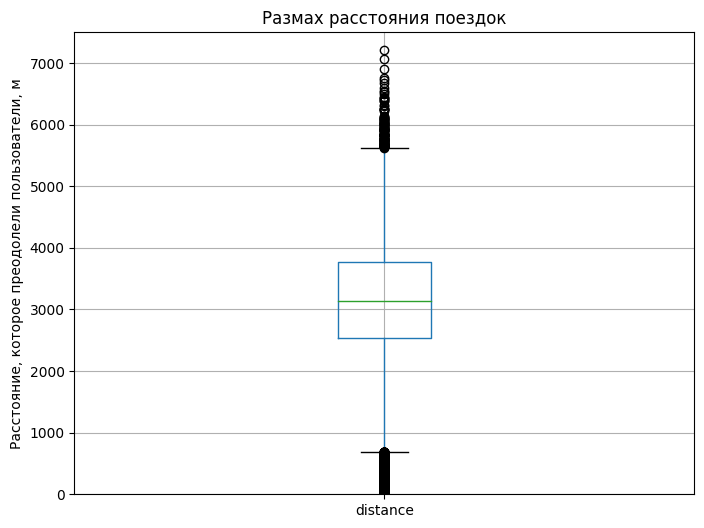

In [31]:
# посторим диаграмму размаха
rides.boxplot(column='distance', figsize=(8, 6))
plt.title('Размах расстояния поездок')
plt.ylim(0, 7500)
plt.ylabel('Расстояние, которое преодолели пользователи, м')
plt.show()

Из графика мы видим, что ориентировочная граница нормального размаха расстояния, которое пользователь преодолел за одну поездку, составляет от 750 м до 5,5 км Более высокие и более низкие значения являются выбросами. Внизу и наверху (от 5,5 км до 6,8 км) они сливаются в линию, что говорит о том, что таких выбросов много. Выше 6,8 км выбросы представлены отделтными точками. Медиана - 3,1 км

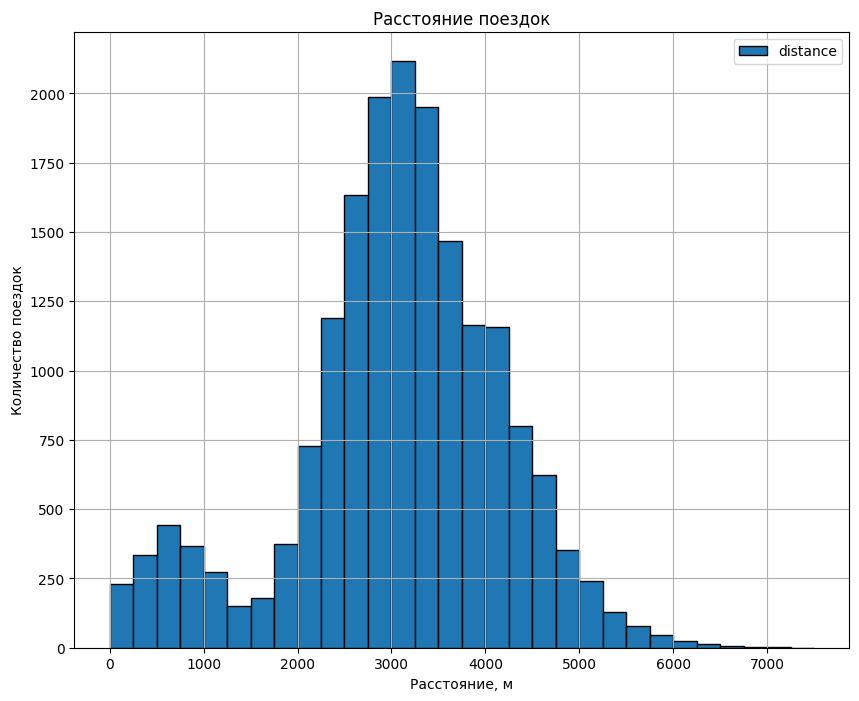

In [32]:
rides['distance'].hist(bins=30, range=(0, 7500), figsize=(10, 8), ec='black', legend=True)
plt.title('Расстояние поездок')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.show()

Как мы видим на гистограмме, наиболее распространены поездки на расстояние 3 - 3,5 км (пик приходится на 3,25 км). Медиана - 3,13 км, среднее - 3,07 км Слева на гистограмме мы видим пик существенно меньшего размера. Он приходится на поездки с расстоянием 750 м

**Изучение продолжительности поездок**

In [33]:
# посмотрим распределение по столбцу с продолжительностью поездок
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

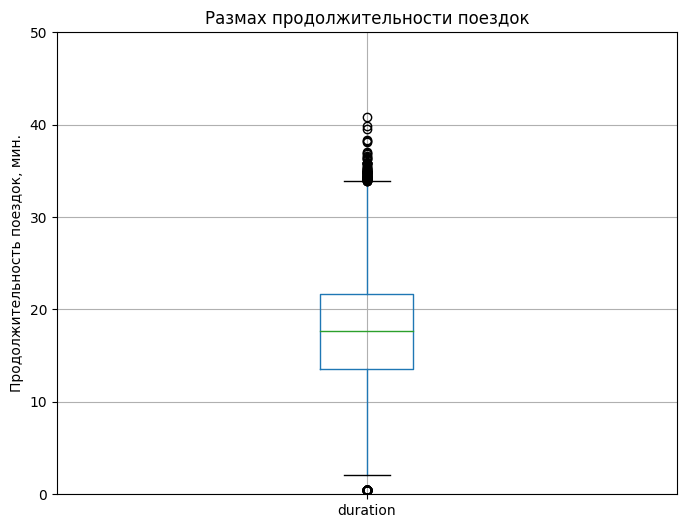

In [34]:
# посторим диаграмму размаха
rides.boxplot(column='duration', figsize=(8, 6))
plt.title('Размах продолжительности поездок')
plt.ylim(0, 50)
plt.ylabel('Продолжительность поездок, мин.')
plt.show()

Как мы видим, ориентировочная граница нормального размаха продолжительности поездок составляет от 2 мин. до 34 мин. Более высокие и более низкие значения являются выбросами. Медиана составляет 17,68 мин.

**Таким образом, в ходе исследования мы установили, что:**

- наиболее часто в представленных данных встречается Пятигорск. В первую тройку входят также Екатеринбург и Ростов-на-Дону. Замыкает список городов Москва: в представленных данных этот город встречается реже всех
- большинство клиентов пользуются сервисом GoFast без подписки (846 против 719). При этом количество имеющих подписку пользователей составляет примерно 46% от общего количества клиентов)
- большая часть пользователей сервиса GoFast - это люди возраста от 22 до 28 лет включительно (в каждой из этих возрастных категорий количество пользователей превышает 100), при этом максимум приходится на возраст 25 лет. Пользователи иных возрастов встречаются существенно реже. Причем меньше всего пользователей, возраст которых близок к 40 годам (на графике это 37, 38, 39 и 43 года), минимум приходится на 39 и на 43 года (таких пользователей всего по одному в каждом из этих возратов)
- ориентировочная граница нормального размаха расстояния, которое пользователь преодолел за одну поездку, составляет от 750 м до 5,5 км; медиана - 3,1 км
- ориентировочная граница нормального размаха продолжительности поездок составляет от 2 мин. до 34 мин.; медиана составляет 17,68 мин.
- типичная поездка на самокате - это поездка на расстояние 3,1 км и продолжительностью 17,7 мин., что соответствует скорости примерно 10,5 км/ч

#### Шаг 4. Объединение данных

Для удобства дальнейшего анализа объединим данные о пользователях, поездках и подписках в один датафрейм

In [35]:
# объединяем данные по столбцу user_id методом merge()
data = users.merge(rides, on='user_id', how='outer')

In [36]:
# выведем первые 20 строчек получившегося датафрейма на экран
data.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11


In [37]:
# Код ревьюера
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(3)
memory usage: 1.2+ MB


In [38]:
# проверим количество пропусков в % для нового датафрейма
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
name,0.000000
age,0.000000
city,0.000000
subscription_type,0.000000
distance,0.000000
duration,0.000000
date,0.000000
month,0.000000


Видим, что объединение данных прошло успешно: в новом датафрейме имеются все необходимые столбцы, пропусков данных нет. Теперь создадим из датафрейма data ещё два датафрейма:
- c данными о пользователях без подписки
- с данными о пользователях с подпиской

In [39]:
# создаем датафрейм с данными о пользователях без подписки
data_free = data.query('subscription_type == "free"').reset_index(drop=True)  

In [40]:
# проверяем получившийся датафрейм - выведем первые 20 строчек
data_free.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2
5,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2
6,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3
7,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4
8,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6
9,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6


In [41]:
# создаем датафрейм с данными о пользователях с подпиской
data_ultra = data.query('subscription_type == "ultra"').reset_index(drop=True)

In [42]:
data_ultra.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11


Теперь мы можем визуализировать информацию о расстоянии и времени поездок для пользователей обеих категорий.

**Изучение данных о расстоянии и времени поездок для пользователей без подписки**

In [43]:
# посмотрим распределение по столбцу с расстояниями поездок
data_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

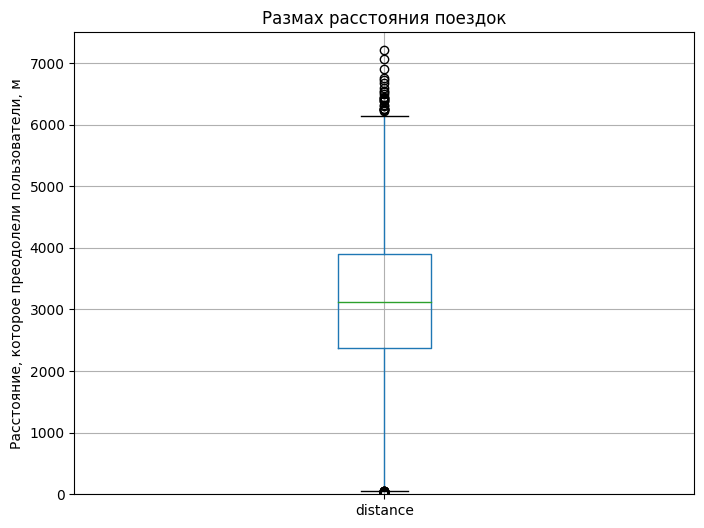

In [44]:
# посторим диаграмму размаха
data_free.boxplot(column='distance', figsize=(8, 6))
plt.title('Размах расстояния поездок')
plt.ylim(0, 7500)
plt.ylabel('Расстояние, которое преодолели пользователи, м')
plt.show()

Из графика мы видим, что ориентировочная граница нормального размаха расстояния, которое пользователи без подписки преодолели за одну поездку, составляет от 100 м до 6,2 км Более высокие и более низкие значения являются выбросами. Медиана - 3,11 км

In [45]:
# посмотрим распределение по столбцу с продолжительностью поездок
data_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

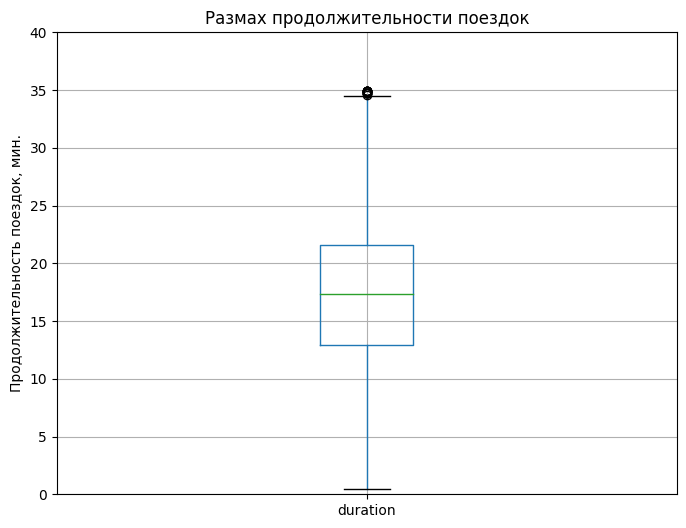

In [46]:
# посторим диаграмму размаха
data_free.boxplot(column='duration', figsize=(8, 6))
plt.title('Размах продолжительности поездок')
plt.ylim(0, 40)
plt.ylabel('Продолжительность поездок, мин.')
plt.show()

Как мы видим, ориентировочная граница нормального размаха продолжительности поездок для пользователей без подписки составляет от 1 мин. до 34 мин. Более высокие и более низкие значения являются выбросами. Медиана составляет 17,34 мин.

**Изучение данных о расстоянии и времени поездок для пользователей с подпиской**

In [47]:
# посмотрим распределение по столбцу с расстояниями поездок
data_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

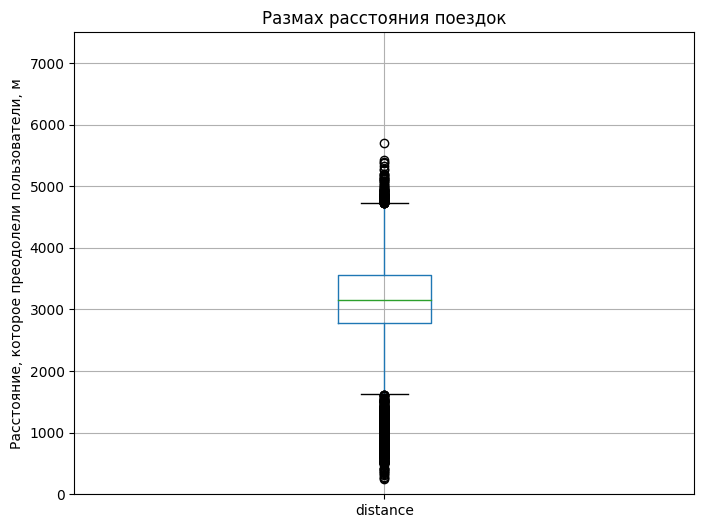

In [48]:
# посторим диаграмму размаха
data_ultra.boxplot(column='distance', figsize=(8, 6))
plt.title('Размах расстояния поездок')
plt.ylim(0, 7500)
plt.ylabel('Расстояние, которое преодолели пользователи, м')
plt.show()

Из графика мы видим, что ориентировочная граница нормального размаха расстояния, которое пользователи с подпиской преодолели за одну поездку, составляет от 1,6 км до 4,6 км Более высокие и более низкие значения являются выбросами. Медиана - 3,15 км

In [49]:
# посмотрим распределение по столбцу с продолжительностью поездок
data_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

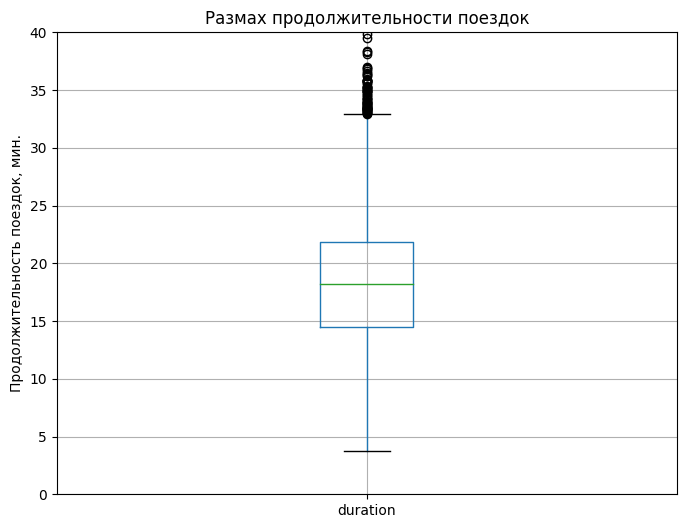

In [50]:
# посторим диаграмму размаха
data_ultra.boxplot(column='duration', figsize=(8, 6))
plt.title('Размах продолжительности поездок')
plt.ylim(0, 40)
plt.ylabel('Продолжительность поездок, мин.')
plt.show()

Как мы видим, ориентировочная граница нормального размаха продолжительности поездок для пользователей с подпиской составляет от 4 мин. до 33 мин. Более высокие и более низкие значения являются выбросами. Медиана составляет 18,18 мин.

**В ходе исследования мы установили, что:**

- ориентировочная граница нормального размаха расстояния, которое пользователи без подписки преодолели за одну поездку, составляет от 100 м до 6,2 км; медиана - 3,11 км
- ориентировочная граница нормального размаха расстояния, которое пользователи с подпиской преодолели за одну поездку, составляет от 1,6 км до 4,6 км; медиана - 3,15 км
- ориентировочная граница нормального размаха продолжительности поездок для пользователей без подписки составляет от 1 мин. до 34 мин.; медиана составляет 17,34 мин.
- ориентировочная граница нормального размаха продолжительности поездок для пользователей с подпиской составляет от 4 мин. до 33 мин.; медиана составляет 18,18 мин.

Вышеуказанные результаты, скорее всего, объясняются наличием среди пользователей без подписки людей, которые пользовались сервисом в первый раз и проехали на самокате некоторое небольшое расстояние просто из желания попробовать (мы видим расстояние в 100 м как нижнюю границу). Имеющие подписку пользуются сервисом регулярно, соответственно, нижняя граница для них - это 1,6 км (т.е. поездки на малые расстояния для них не характерны). При этом пользователи без подписки имеют более высокую верхнюю границу расстояния поездки (6,2 км против 4,6 км) Нижняя граница времени поездки для пользователей без подписки составляет всего 1 мин., что в 4 раза меньше, чем в категории с подпиской (что, очевидно, также связано с "тестовыми" поездками на малые расстояния).

#### Шаг 5. Подсчёт выручки

**Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц**

In [51]:
# создаем сводную таблицу для пользователей без подписки с данными о суммарном расстоянии и суммарном времени
data_1 = data_free.pivot_table(index=['user_id', 'month'], values=['distance', 'duration'], aggfunc='sum').reset_index\
(level=['month', 'user_id'])

In [52]:
# создаем сводную таблицу для пользователей без подписки с данными о количесте поездок
data_2 = data_free.pivot_table(index=['user_id', 'month'], aggfunc={'user_id':'count'})
data_2.columns = ['ride_amount']
data_2 = data_2.reset_index(level=['month', 'user_id'])

In [53]:
# объединяем предыдущие 2 таблицы и создаем таблицу для пользователей без подписки с данными о суммарном расстоянии, количестве
# поездок и суммарном времени для каждого пользователя за каждый месяц
data_cons_free = data_1.merge(data_2, on=['user_id', 'month'], how='outer')

In [54]:
# проверим количество пропусков в % для нового датафрейма
pd.DataFrame(round(data_cons_free.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
month,0.000000
distance,0.000000
duration,0.000000
ride_amount,0.000000


In [55]:
# проверяем получившийся датафрейм - выведем первые 20 строчек
data_cons_free.head(20)

,user_id,month,distance,duration,ride_amount
0,700,1,2515.690719,14.944286,1
1,700,2,13446.659764,85.829845,5
2,700,3,3798.334905,18.243756,1
3,700,4,2984.551206,15.424899,1
4,700,6,5927.650988,28.077657,2
5,700,7,4399.206279,20.595752,2
6,700,8,4071.654669,16.370546,1
7,700,10,6322.578618,42.621488,2
8,700,11,8735.782625,31.116714,3
9,701,1,2676.472894,17.470598,1


In [56]:
# создаем сводную таблицу для пользователей с подпиской с данными о суммарном расстоянии и суммарном времени
data_3 = data_ultra.pivot_table(index=['user_id', 'month'], values=['distance', 'duration'], aggfunc='sum').reset_index\
(level=['month', 'user_id'])

In [57]:
# создаем сводную таблицу для пользователей с подпиской с данными о количесте поездок
data_4 = data_ultra.pivot_table(index=['user_id', 'month'], aggfunc={'user_id':'count'})
data_4.columns = ['ride_amount']
data_4 = data_4.reset_index(level=['month', 'user_id'])

In [58]:
# объединяем предыдущие 2 таблицы и создаем таблицу для пользователей с подпиской с данными о суммарном расстоянии, количестве
# поездок и суммарном времени для каждого пользователя за каждый месяц
data_cons_ultra = data_3.merge(data_4, on=['user_id', 'month'], how='outer')

In [59]:
# проверим количество пропусков в % для нового датафрейма
pd.DataFrame(round(data_cons_ultra.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
month,0.000000
distance,0.000000
duration,0.000000
ride_amount,0.000000


In [60]:
# проверяем получившийся датафрейм - выведем первые 20 строчек
data_cons_ultra.head(20)

,user_id,month,distance,duration,ride_amount
0,1,1,7027.511294,41.416640,2
1,1,4,754.159807,6.232113,1
2,1,8,6723.470560,44.776802,2
3,1,10,5809.911100,31.578017,2
4,1,11,7003.499363,53.397424,3
5,1,12,6751.629942,27.203912,2
6,2,3,10187.723006,60.959959,3
7,2,4,6164.381824,39.048633,2
8,2,6,3255.338202,13.851127,1
9,2,7,6780.722964,46.170157,2


**Добавим в датафрейм data_cons столбец с помесячной выручкой, которую принес каждый пользователь**

Вначале посчитаем **помесячную выручку для пользователей без подписки**. Как следует из представленных данных, для них действует следующий тариф:

- абонентская плата отсутствует
- стоимость одной минуты поездки — 8 рублей
- стоимость старта (начала поездки) — 50 рублей

Таким образом, для данной категории пользователей помесячная выручка будет рассчитываться по формуле:

*стоимость старта * количество поездок + стоимость одной минуты * продолжительность поездки*

Минуты при подсчете стоимости округляем до ближайшего целого числа.

In [61]:
# добавляем в датафрейм столбец с данными о помесячной выручке каждого пользователя
data_cons_free['revenue_per_month'] = 50 * data_cons_free['ride_amount'] + 8 * data_cons_free['duration'].round()

In [62]:
# проверим количество пропусков
pd.DataFrame(round(data_cons_free.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
month,0.000000
distance,0.000000
duration,0.000000
ride_amount,0.000000
revenue_per_month,0.000000


In [63]:
# проверяем получившийся датафрейм - выведем первые 20 строчек
data_cons_free.head(20)

,user_id,month,distance,duration,ride_amount,revenue_per_month
0,700,1,2515.690719,14.944286,1,170.0
1,700,2,13446.659764,85.829845,5,938.0
2,700,3,3798.334905,18.243756,1,194.0
3,700,4,2984.551206,15.424899,1,170.0
4,700,6,5927.650988,28.077657,2,324.0
5,700,7,4399.206279,20.595752,2,268.0
6,700,8,4071.654669,16.370546,1,178.0
7,700,10,6322.578618,42.621488,2,444.0
8,700,11,8735.782625,31.116714,3,398.0
9,701,1,2676.472894,17.470598,1,186.0


Теперь посчитаем **помесячную выручку для пользователей с подпиской**. Как следует из представленных данных, для них действует следующий тариф:

- абонентская плата — 199 рублей в месяц
- стоимость одной минуты поездки — 6 рублей
- стоимость старта — бесплатно

Таким образом, для данной категории пользователей помесячная выручка будет рассчитываться по формуле:

*абонентская плата + стоимость одной минуты * продолжительность поездки*

Минуты при подсчете стоимости округляем до ближайшего целого числа.

In [64]:
# добавляем в датафрейм столбец с данными о помесячной выручке каждого пользователя
data_cons_ultra['revenue_per_month'] = 199 + 6 * data_cons_ultra['duration'].round()

In [65]:
# проверим количество пропусков
pd.DataFrame(round(data_cons_ultra.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
user_id,0.000000
month,0.000000
distance,0.000000
duration,0.000000
ride_amount,0.000000
revenue_per_month,0.000000


In [66]:
# проверяем получившийся датафрейм - выведем первые 20 строчек
data_cons_ultra.head(20)

,user_id,month,distance,duration,ride_amount,revenue_per_month
0,1,1,7027.511294,41.416640,2,445.0
1,1,4,754.159807,6.232113,1,235.0
2,1,8,6723.470560,44.776802,2,469.0
3,1,10,5809.911100,31.578017,2,391.0
4,1,11,7003.499363,53.397424,3,517.0
5,1,12,6751.629942,27.203912,2,361.0
6,2,3,10187.723006,60.959959,3,565.0
7,2,4,6164.381824,39.048633,2,433.0
8,2,6,3255.338202,13.851127,1,283.0
9,2,7,6780.722964,46.170157,2,475.0


Таким образом, мы получили данные о помесячной выручке, которую приносят сервису аренды самокатов GoFast пользователи с подпиской Ultra и без нее. Анализом полученных данных мы займемся на следующем шаге нашего исследования.

#### Шаг 6. Проверка гипотез

**Первая гипотеза**, которую нам нужно проверить: **тратят ли пользователи с подпиской больше времени на поездки?**
Сформируем нулевую и альтернативную гипотезы:
 - H0 - пользователи с подпиской и без подписки тратят одираковое время на поездки
 - H1 - пользователи с подпиской тратят больше времени на поездки
 
Используем статистический тест для независимых выборок -  метод scipy.stats.ttest_ind(array1, array2, equal_var). Параметры метода:
- array1, array2 — наборы значений, которые содержат выборки
- equal_var (от англ. equal variance — «равная дисперсия») — необязательный параметр. Он управляет тем, будет ли метод считать равными дисперсии выборок. Передаётся как equal_var=True или equal_var=False (True — считать, False — не считать). 

По умолчанию используется значение True. При этом из **обучающего курса Яндекс.Практикум** следует: "если выборки достаточно велики (30 и больше значений) и равны по размеру между собой, то такой подход оправдан. **Симуляции, проведённые учёными, показывают, что даже если дисперсии на самом деле не равны, то тест редко ошибается**." 


In [67]:
# задаем уровень статистической значимости (если p-value окажется меньше него, отвергнем гипотезу)
alpha = 0.05
results = st.ttest_ind(data[data['subscription_type'] == 'ultra']['duration'], data[data['subscription_type']\
== 'free']['duration'], alternative='greater')
# выводим на экран получившееся p-значение
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645613e-34
Отвергаем нулевую гипотезу


Таким образом, мы отвергаем нулевую гипотезу. Получается, что пользователи с подпиской тратят больше времени на поездки. Учитывая, что помимо поминутной оплаты продолжительности поездок на тарифе с подпиской Ultra пользователи оплачивают и абонентскую плату (199 рублей в месяц), возможно, пользователи с подпиской «выгоднее» для компании. Гипотезу о том, будет ли выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки, мы проверим на следующих шагах.

**Вторая гипотеза**, которую нам нужно проверить: **можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров?** Сформируем нулевую и альтернативную гипотезы:

- H0 - расстояние, которое проезжают пользователи с подпиской за одну поездку, составляет 3130 метров
- H1 - расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров

Для проведения одностороннего теста нужно использовать метод scipy.stats.ttest_1samp(). Т.к. альтернативная гипотеза левосторонняя, в качестве аргумента указываем alternative='less'.

In [68]:
# задаем уровень статистической значимости (если p-value окажется меньше него, отвергнем гипотезу)
alpha = 0.05
results = st.ttest_1samp(data[data['subscription_type'] == 'ultra']['distance'], 3130, alternative='less')
# выводим на экран получившееся p-значение
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.08046311521502145
Не получилось отвергнуть нулевую гипотезу


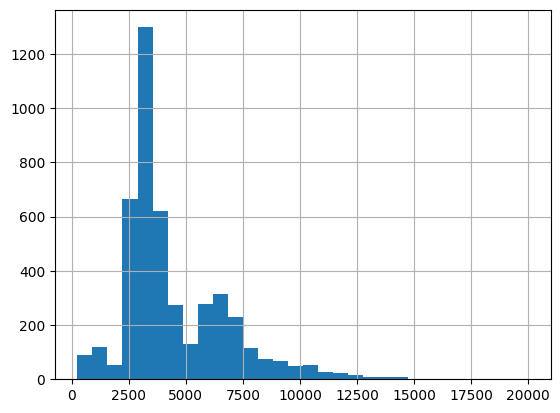

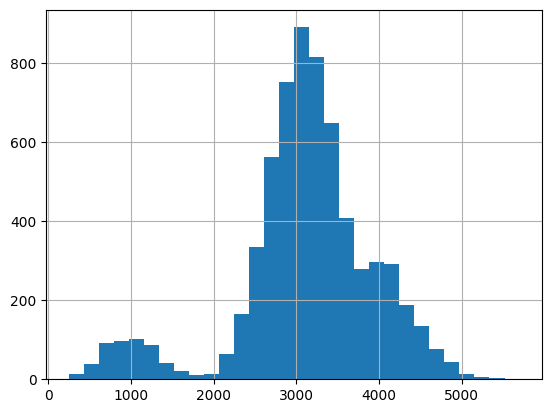

In [69]:
# Код ревьюера

# Твоя выборка
data_cons_ultra['distance'].hist(bins = 30)
plt.show()

# Правильная выборка
sample_1 = data[data['subscription_type'] == 'ultra']['distance']
sample_1.hist(bins = 30)
plt.show()

Таким образом, нулевую гипотезу отвергнуть не получилось. Получается, что **расстояние, которое проезжают пользователи с подпиской за одну поездку, составляет 3130 метров**. Как следует из представленных данных, расстояние одной поездки в 3130 метров является оптимальным с точки зрения износа самоката. Получается, что результат проверки нашей гипотезы также говорит о выгоде для компании пользователей с подпиской.  

**Третья гипотеза**, которую нам нужно проверить: **будет ли выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки?** формируем нулевую и альтернативную гипотезы:

- H0 - выручка от пользователей с подпиской равна выручке от пользователей без подписки
- H1 - выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

Используем статистический тест для независимых выборок -  метод scipy.stats.ttest_ind(array1, array2, equal_var). Параметры метода:
- array1, array2 — наборы значений, которые содержат выборки
- equal_var (от англ. equal variance — «равная дисперсия») — необязательный параметр. Он управляет тем, будет ли метод считать равными дисперсии выборок. Передаётся как equal_var=True или equal_var=False (True — считать, False — не считать). 

По умолчанию используется значение True. При этом из **обучающего курса Яндекс.Практикум** следует: "если выборки достаточно велики (30 и больше значений) и равны по размеру между собой, то такой подход оправдан. **Симуляции, проведённые учёными, показывают, что даже если дисперсии на самом деле не равны, то тест редко ошибается**." 

In [70]:
# задаем уровень статистической значимости (если p-value окажется меньше него, отвергнем гипотезу)
alpha = 0.05
results = st.ttest_ind(data_cons_ultra['revenue_per_month'], data_cons_free['revenue_per_month'], alternative='greater')
# выводим на экран получившееся p-значение
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.3546897309064956e-37
Отвергаем нулевую гипотезу


Таким образом, мы отвергаем нулевую гипотезу в пользу альтернативной: **выручка от пользователей с подпиской будет выше, чем выручка от пользователей без подписки**. 

**В пункте 6.4 описания проекта** содержится следующее задание: "*Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?*"

**Ответ:** в данном случае речь идет о проверке гипотезы о равенстве средних для зависимых (парных) выборок (т.е. до обновления серверов и после обновления). Для проверки гипотезы необходимо использовать метод scipy.stats.ttest_rel(), которому необходимо передать два параметра: наборы данных до и после. 

#### Шаг 7. Распределения

**В описании проекта задания шага 7 отмечены как НЕОБЯЗАТЕЛЬНЫЕ**. 

**Задание:** *отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.*

In [71]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4
# зададим параметры нормального распределения равными мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
# задаём нормальное распределение
distr = st.norm(mu, sigma) 
# считаем вероятность хвоста слева от 399,5 тысяч
result = distr.cdf(399500)
print(result)

0.15371708296369768


Т.е. вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет чуть более 15%

**Общий вывод:**

для проведения настоящего исследования были использованы данные сервиса аренды самокатов GoFast для нескольких городов (Екатеринбург, Краснодар, Москва, Омск, Пятигорск, Ростов-на-Дону, Сочи и Тюмень) о пользователях, их поездках и подписках (пользователи — users_go.csv, поездки — rides_go.csv, подписки — subscriptions_go.csv).

Для проведения анализа мы объединили данные о пользователях, поездках и подписках в один датафрейм, на основе которого создали таблицы с данными:
- о пользователях без подписки
- о пользователях с подпиской Ultra

после чего создали таблицы с данными о суммарном расстоянии, количестве поездок и суммарном времени для каждого пользователя сервиса GoFast за каждый месяц для каждой из указанных выше категорий пользователей.
В каждую из таблиц (т.е. для пользователей с подпиской и пользователей без подписки) мы добавили столбец с рассчитанной помесячной выручкой, которую принес сервису GoFast каждый пользователь.
В ходе дальнейшего исследования мы установили, что:

- наиболее часто в представленных данных встречается Пятигорск. В первую тройку входят также Екатеринбург и Ростов-на-Дону. Замыкает список городов Москва: в представленных данных этот город встречается реже всех

- большинство клиентов пользуются сервисом GoFast без подписки (846 против 719). При этом количество имеющих подписку пользователей составляет примерно 46% от общего количества клиентов

- большая часть пользователей сервиса GoFast - это люди возраста от 22 до 28 лет включительно (в каждой из этих возрастных категорий количество пользователей превышает 100), при этом максимум приходится на возраст 25 лет. Пользователи иных возрастов встречаются существенно реже. Причем меньше всего пользователей, возраст которых близок к 40 годам. Ориентировочная граница нормального размаха расстояния, которое пользователь преодолел за одну поездку, составляет от 13 до 48 лет

- ориентировочная граница нормального размаха расстояния, которое пользователь преодолел за одну поездку, составляет от 750 м до 5,5 км; медиана - 3,1 км

- ориентировочная граница нормального размаха продолжительности поездок составляет от 2 мин. до 34 мин.; медиана составляет 17,68 мин.

- типичная поездка на самокате - это поездка на расстояние 3,1 км и продолжительностью 17,7 мин., что соответствует скорости примерно 10,5 км/ч

- ориентировочная граница нормального размаха расстояния, которое пользователи без подписки преодолели за одну поездку, составляет от 100 м до 6,2 км; медиана - 3,11 км

- ориентировочная граница нормального размаха расстояния, которое пользователи с подпиской преодолели за одну поездку, составляет от 1,6 км до 4,6 км; медиана - 3,15 км

- ориентировочная граница нормального размаха продолжительности поездок для пользователей без подписки составляет от 1 мин. до 34 мин.; медиана составляет 17,34 мин.

- ориентировочная граница нормального размаха продолжительности поездок для пользователей с подпиской составляет от 4 мин. до 33 мин.; медиана составляет 18,18 мин.

Вышеуказанные результаты, скорее всего, объясняются наличием среди пользователей без подписки людей, которые пользовались сервисом в первый раз и проехали на самокате некоторое небольшое расстояние просто из желания попробовать (мы видим расстояние в 100 м как нижнюю границу). Имеющие подписку пользуются сервисом регулярно, соответственно, нижняя граница для них - это 1,6 км (т.е. поездки на малые расстояния для них не характерны). При этом пользователи без подписки имеют более высокую верхнюю границу расстояния поездки (6,2 км против 4,6 км). Нижняя граница времени поездки для пользователей без подписки составляет всего 1 мин., что в 4 раза меньше, чем в категории с подпиской (что, очевидно, также связано с "тестовыми" поездками на малые расстояния).

Также мы проверили ряд гипотез. Результаты приведены ниже:

-  пользователи с подпиской тратят больше времени на поездки 

- расстояние, которое проезжают пользователи с подпиской за одну поездку, составляет 3130 метров

- выручка от пользователей с подпиской будет выше, чем выручка от пользователей без подписки.

Как следует из представленных данных, расстояние одной поездки в 3130 метров является оптимальным с точки зрения износа самоката. Таким образом, учитывая:

- оптимальный износ самокатов компании пользователями с подпиской Ultra 

- более высокую продолжительность поездок

- наличие абонентской платы на тарифе с подпиской Ultra (199 рублей в месяц) помимо поминутной оплаты продолжительности поездок

- более высокий размер выручки, которую пользователи с подпиской принесут компании

можно прийти к выводу о том, что намерение продакт-менеджеров сервиса увеличить количество пользователей с подпиской является целесообразным и оправданным.
